In [43]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
import skimage
from skimage.transform import resize
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod
from art.utils import load_dataset

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

# Increasing Matplotlib font size
matplotlib.rcParams.update({"font.size": 14})

In [44]:
class_names = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
class_names_label = {class_name: i for i, class_name in enumerate(class_names)}

IMAGE_SIZE = (150, 150)

In [45]:
def load_data():
    DIRECTORY = r"C:\dataset"
    CATEGORY = ["train", "test"]
    
    output = []
    
    for category in CATEGORY:
        path = os.path.join(DIRECTORY, category)
        images = []
        labels = []
        
        print("Loading {}".format(category))
        
        for folder in os.listdir(path):
            label = class_names.index(folder)
            
            for file in os.listdir(os.path.join(path, folder)):
                img_path = os.path.join(os.path.join(path, folder), file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype='float32')
        labels = np.array(labels, dtype='int32')
        
        output.append((images, labels))
        
    return output


In [46]:
(train_images,train_labels),(test_images,test_labels)=load_data()

Loading train
Loading test


In [47]:
train_images,train_labels=shuffle(train_images,train_labels,random_state=25)

In [48]:
from tensorflow.keras.models import load_model
model = load_model('updated_model.h5')

In [49]:
from art.attacks.evasion import NewtonFool

In [50]:
import numpy as np

def candidate_data(test_images, test_labels, n):
    cx_test = []
    cy_test = []

    unique_classes = np.unique(test_labels)  # Get the unique classes in y_test
    
    for class_label in unique_classes:
        indices = np.where(test_labels == class_label)[0]  # Find indices where class_label occurs
        selected_indices = indices[:n]  # Select the first n indices

        cx_test.append(test_images[selected_indices].copy())
        cy_test.append(test_labels[selected_indices].copy())

    cx_test = np.concatenate(cx_test)
    cy_test = np.concatenate(cy_test)

    return cx_test, cy_test


In [51]:
sample_test, sample_label=candidate_data(test_images, test_labels, 10)

In [52]:
# Create a ART TensorFlow v2 classifier for the target TensorFlow model
artclassifier = KerasClassifier(model=model, 
                                    clip_values=(0, 255), channels_first=False)

In [53]:
attack_newt = NewtonFool(classifier=artclassifier, max_iter=10, batch_size=20,eta=0.01)

In [54]:
def implement_attack(model, attack, sample_test, test_labels, attack_name):
    # Generate the adversarial examples
    x_test_adv = attack.generate(sample_test)
    performance_metrics = model.evaluate(x_test_adv, test_labels)
    predictions = model.predict(x_test_adv)

    # Convert 1-dimensional arrays to 2-dimensional
    if len(test_labels.shape) == 1:
        test_labels = np.expand_dims(test_labels, axis=1)
    if len(predictions.shape) == 1:
        predictions = np.expand_dims(predictions, axis=1)

    report = classification_report(
        np.argmax(test_labels, axis=1),
        np.argmax(predictions, axis=1),
        output_dict=True
    )

    report = report['weighted avg']
    report.update({'Loss': performance_metrics[0]})
    report.update({'Accuracy': performance_metrics[1]})
    report.update({'Attack': attack_name})

    return report, x_test_adv, predictions


In [55]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [56]:
report, x_test_adv, predictions = implement_attack(model, attack=attack_newt, sample_test=sample_test, test_labels=sample_label, attack_name='Newton fool attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

C:\Users\sihus\anaconda3\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


NewtonFool:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\sihus\anaconda3\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall

In [57]:
accuracy_after_attack1 = model.evaluate(x_test_adv, sample_label)
print("Accuracy after Newton Fool Attack:", accuracy_after_attack1[1])

Accuracy after Newton Fool Attack: 0.3


Adversarial test image
Actual label: CNV
Predicted label: DME


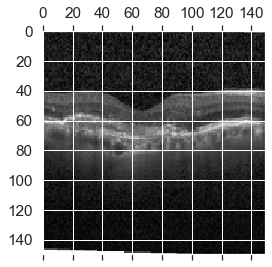

In [58]:
actual_label_index = test_labels[0]  
actual_label_name = class_names[actual_label_index]

predicted_label_index = np.argmax(predictions[0])
predicted_label_name = class_names[predicted_label_index]

print("Adversarial test image")
print("Actual label: {}".format(actual_label_name))
print("Predicted label: {}".format(predicted_label_name))

normalized_image = x_test_adv[0] / 255.0
plt.matshow(normalized_image)
plt.show()


In [59]:
from art.attacks.evasion import SpatialTransformation

In [60]:
sample_test, sample_label=candidate_data(test_images, test_labels, 10)

In [61]:
attack_spat = SpatialTransformation(artclassifier, num_translations=2, max_rotation=10, max_translation=15)

In [62]:
report, x_test_adv, predictions = implement_attack(model, attack=attack_spat, sample_test=sample_test, test_labels=sample_label, attack_name='Spatial transformation attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation

Spatial transformation:   0%|          | 0/4 [00:00<?, ?it/s]

C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
accuracy_after_attack2 = model.evaluate(x_test_adv, sample_label)
print("Accuracy after Spatial Transformation Attack:", accuracy_after_attack2[1])

Accuracy after Spatial Transformation Attack: 0.45


Adversarial test image
Actual label: CNV
Predicted label: DME


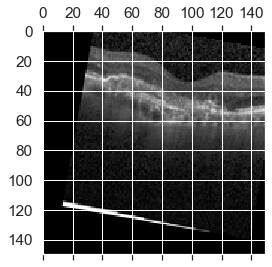

In [64]:
actual_label_index = test_labels[0]  
actual_label_name = class_names[actual_label_index]

predicted_label_index = np.argmax(predictions[0])
predicted_label_name = class_names[predicted_label_index]

print("Adversarial test image")
print("Actual label: {}".format(actual_label_name))
print("Predicted label: {}".format(predicted_label_name))

normalized_image = x_test_adv[0] / 255.0
plt.matshow(normalized_image)
plt.show()


In [65]:
artclassifier2 = KerasClassifier(model=model, clip_values=(0, 255), use_logits=False)

In [66]:
from art.attacks.extraction import CopycatCNN
cc_attack = CopycatCNN(classifier = artclassifier2, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100)

In [67]:
def train_percentage(n):
   
    num_imgs = train_images.shape[ 0 ]
    num_poisoned_images = n
    print( 'Percentage of access to train images', num_poisoned_images*100 / num_imgs )
    idx = np.arange( num_imgs, dtype=int )
    np.random.shuffle( idx )
    candidate_images = np.copy( train_images[ idx[ :num_poisoned_images ] ] )
    target_labels=np.copy( train_labels[ idx[ :num_poisoned_images ] ] )
    return candidate_images,target_labels

In [68]:
x_extr,y_extr = train_percentage(750)

Percentage of access to train images 5.133118883033331


In [69]:
stolen_classifier = cc_attack.extract(x_extr,y_extr,thieved_classifier=artclassifier2)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 9s 90ms/sample - loss: 3.0053 - accuracy: 0.5600
Epoch 2/5
100/100 [==============================] - 8s 84ms/sample - loss: 2.3312 - accuracy: 0.7400
Epoch 3/5
100/100 [==============================] - 9s 89ms/sample - loss: 1.6944 - accuracy: 0.8400
Epoch 4/5
100/100 [==============================] - 9s 90ms/sample - loss: 1.6938 - accuracy: 0.8300
Epoch 5/5
100/100 [==============================] - 9s 88ms/sample - loss: 1.6592 - accuracy: 0.8500


In [70]:
stolen_classifier._model.evaluate(test_images,test_labels)

[2.5079632632988544, 0.5609504]

In [71]:
from art.attacks.extraction import CopycatCNN
cc_attack = CopycatCNN(classifier = artclassifier2, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100)

In [72]:
x_extr,y_extr = train_percentage(3000)

Percentage of access to train images 20.532475532133326


In [73]:
stolen_classifier = cc_attack.extract(x_extr,y_extr,thieved_classifier=artclassifier2)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 9s 88ms/sample - loss: 2.0841 - accuracy: 0.7100
Epoch 2/5
100/100 [==============================] - 8s 85ms/sample - loss: 2.0414 - accuracy: 0.8200
Epoch 3/5
100/100 [==============================] - 9s 86ms/sample - loss: 1.7860 - accuracy: 0.8400
Epoch 4/5
100/100 [==============================] - 8s 84ms/sample - loss: 1.4465 - accuracy: 0.9200
Epoch 5/5
100/100 [==============================] - 8s 83ms/sample - loss: 1.4315 - accuracy: 0.8900


In [74]:
stolen_classifier._model.evaluate(test_images,test_labels)

[2.9840727798209703, 0.46280992]

In [75]:
from art.attacks.extraction import CopycatCNN
cc_attack = CopycatCNN(classifier = artclassifier2, batch_size_fit=5, 
                        batch_size_query=10,
                        nb_epochs=5,
                        nb_stolen=100)

In [76]:
x_extr,y_extr = train_percentage(7400)

Percentage of access to train images 50.6467729792622


In [77]:
stolen_classifier = cc_attack.extract(x_extr,y_extr,thieved_classifier=artclassifier2)

Train on 100 samples
Epoch 1/5
100/100 [==============================] - 9s 87ms/sample - loss: 2.4390 - accuracy: 0.7000
Epoch 2/5
100/100 [==============================] - 9s 89ms/sample - loss: 2.4842 - accuracy: 0.7600
Epoch 3/5
100/100 [==============================] - 9s 87ms/sample - loss: 2.2251 - accuracy: 0.8000
Epoch 4/5
100/100 [==============================] - 9s 86ms/sample - loss: 1.7927 - accuracy: 0.8200
Epoch 5/5
100/100 [==============================] - 9s 86ms/sample - loss: 1.5930 - accuracy: 0.8500


In [78]:
stolen_classifier._model.evaluate(test_images,test_labels)

[3.6592316647206458, 0.36570248]

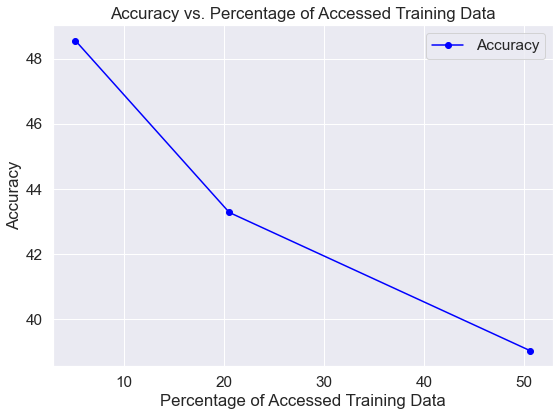

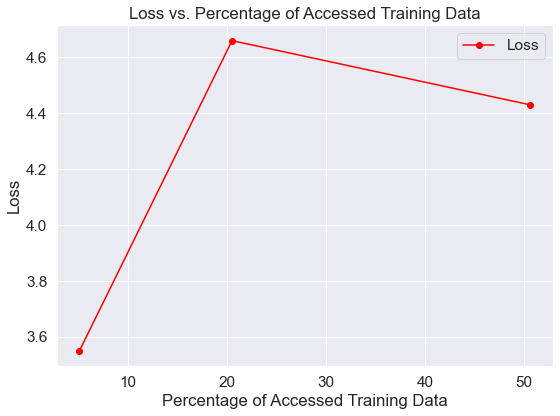

In [79]:
# Results of CopycatCNN attacks for different percentages of accessed training data
percentages = [5.13, 20.53, 50.65]  
accuracies = [48.55, 43.28, 39.04]   
losses = [3.55, 4.66, 4.43]       

# Plotting accuracy results
plt.figure(figsize=(8, 6))
plt.plot(percentages, accuracies, marker='o', color='blue', label='Accuracy')
plt.xlabel('Percentage of Accessed Training Data')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Percentage of Accessed Training Data')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plotting loss results
plt.figure(figsize=(8, 6))
plt.plot(percentages, losses, marker='o', color='red', label='Loss')
plt.xlabel('Percentage of Accessed Training Data')
plt.ylabel('Loss')
plt.title('Loss vs. Percentage of Accessed Training Data')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [80]:
from art.attacks.evasion import DeepFool

In [81]:
sample_test, sample_label=candidate_data(test_images, test_labels, 10)

In [82]:
attack_deepf = DeepFool(classifier=artclassifier, max_iter=10, batch_size=20,epsilon=0.01)

In [83]:
report, x_test_adv, predictions = implement_attack(model, attack=attack_deepf, sample_test=sample_test, test_labels=sample_label, attack_name='Deepfool attack')
perturbation = np.mean(np.abs((x_test_adv - sample_test)))
report['perturbation']=perturbation


DeepFool:   0%|          | 0/2 [00:00<?, ?it/s]

C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\sihus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
accuracy_after_attack3 = model.evaluate(x_test_adv, sample_label)
print("Accuracy after DeepFool Attack:", accuracy_after_attack3[1])

Accuracy after DeepFool Attack: 0.2


Adversarial test image
Actual label: CNV
Predicted label: DME


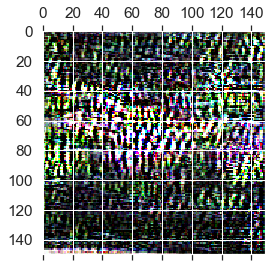

In [85]:
actual_label_index = test_labels[0]  
actual_label_name = class_names[actual_label_index]

predicted_label_index = np.argmax(predictions[0])
predicted_label_name = class_names[predicted_label_index]

print("Adversarial test image")
print("Actual label: {}".format(actual_label_name))
print("Predicted label: {}".format(predicted_label_name))

normalized_image = x_test_adv[0] / 255.0
plt.matshow(normalized_image)
plt.show()


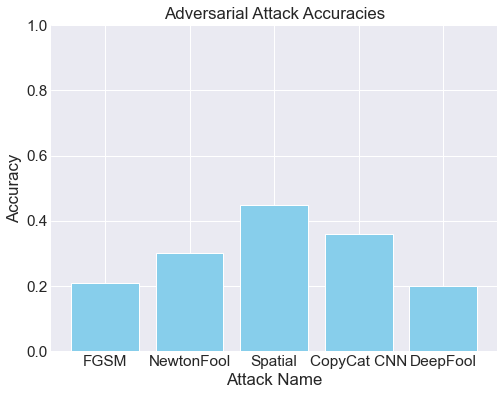

In [101]:
import matplotlib.pyplot as plt

attack_names = ['FGSM','NewtonFool', 'Spatial', 'CopyCat CNN', 'DeepFool']
accuracies = [0.21,0.30, 0.45, 0.36, 0.20]

plt.figure(figsize=(8, 6))
plt.bar(attack_names, accuracies, color='skyblue')
plt.title('Adversarial Attack Accuracies')
plt.xlabel('Attack Name')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  
plt.show()
